# Do you know your stroke risk?

Source of the data: https://www.sciencedirect.com/science/article/pii/S0933365719302295?via%3Dihub
Liu, Tianyu; Fan, Wenhui; Wu, Cheng (2019), “Data for: A hybrid machine learning approach to cerebral stroke prediction based on imbalanced medical-datasets”, Mendeley Data, V1, doi: 10.17632/x8ygrw87jw.1

The medical dataset contains 43,400 records of potential patients which includes 783 occurrences of stroke. 

Cerebral stroke has become a significant global public health issue. The ideal solution to this concern is to prevent in advance by controlling related metabolic factors. However, it is difficult for medical staff to decide whether special precautions are needed for a potential patient only based on the monitoring of physiological indicators unless they are obviously abnormal. This project builds a machine learning model to predict whether someone is at risk of having a stroke.

The data in each row includes numerical factors, such as age and average glucose levels, and categorical factors, such as "has heart disease" (yes or no), work type, and smoking status. This is not an exhaustive list. We use this data to determine which factors contribute to having a stroke, and among those which hold the most weight.

## Basic analysis of the input dataset

In [1]:
# Dependencies and Setup
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
#import seaborn as sns
%matplotlib inline
#sns.set_style('whitegrid')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#tensorflow.keras.__version__
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

# Read the golf course dataset
input_csv = pd.read_csv("data/stroke_dataset.csv", delimiter=',', skipinitialspace=True)
input_csv.shape

0.7.0


(43400, 12)

### Neural Network Code Below

In [2]:
def neural_net(X,y, filename):
    dim = X.shape[1]
    

    
    print("**********************")
    print(f"Before X: {X.shape}")
    print(f"Before y: {y.shape}")
    
    sm = SMOTE()
    X, y = sm.fit_resample(X,y)
      
    print("**********************")
    print(f"SMOTED X: {X.shape}")
    print(f"SMOTED y: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 50)
    
    X_scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    # Step 1: Label-encode data set
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    encoded_y_train = label_encoder.transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)
    # Step 2: Convert encoded labels to one-hot-encoding
    y_train_categorical = to_categorical(encoded_y_train)
    y_test_categorical = to_categorical(encoded_y_test)
    
    print(f"X_scaler: {X_scaler}")
    unit_num = 55
    
    # Create model and add layers
    model = Sequential()
    model.add(Dense(units=unit_num, activation='relu', input_dim=dim))
    model.add(Dense(units=unit_num, activation='relu'))
    model.add(Dense(units=unit_num, activation='relu'))
    model.add(Dense(units=unit_num, activation='relu'))
    model.add(Dense(units=unit_num, activation='relu'))
    
    
#     model.add(Dense(units=unit_num, activation='relu'))    
#     model.add(Dense(units=unit_num), activation='relu'))
    model.add(Dense(units=2, activation='softmax'))

    #categorical_crossentropy
    
    # Compile and fit the model
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.PrecisionAtRecall(recall = 0.85)])
    
    model.summary()
    model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=1
    )
    model_result = model.evaluate(
        X_test_scaled, y_test_categorical, verbose=2)
    
    print("/n")
    print("Test Results")
    print(f"Normal Neural Network - Loss: {model_result[0]}, Accuracy: {model_result[1]}")
    
    
    
    uniqueValues_train, occurCount_train = np.unique(y_train, return_counts=True)
    uniqueValues_test, occurCount_test = np.unique(y_test, return_counts=True)
    print(f"train unique values {uniqueValues_train}")
    print(f"train occur count {occurCount_train}")
    
    print(f"test unique values {uniqueValues_test}")
    print(f"test occur count {occurCount_test}")
   
    model.save(filename+".h5")
    
    return (X, y)

In [3]:
# Display the input data for preview
input_csv

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


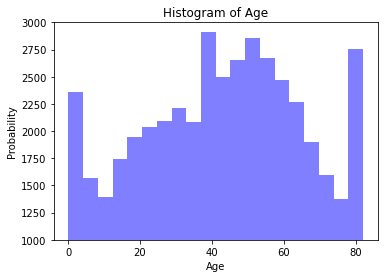

In [4]:
#plotting histogram of age

x = input_csv['age']
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.ylim([1000, 3000])
# add a 'best fit' line
#y = mlab.normpdf(bins, mu, sigma)

plt.xlabel('Age')
plt.ylabel('Probability')
plt.title(r'Histogram of Age')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

### Looking into balanced datasets

In [5]:
stroke_data_df = input_csv.copy(deep=True)

In [6]:
stroke_data_df = stroke_data_df.dropna()


In [7]:
stroke_data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
6,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [8]:
stroke_data_df.shape

(29072, 12)

### Isolating Positive Stroke Data

In [9]:
stroke_positive = stroke_data_df[stroke_data_df['stroke'] == 0]

In [10]:

stroke_positive.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
6,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [11]:
stroke_positive.shape

(28524, 12)

## Isolating Negative Stroke Data

In [12]:
stroke_negative = stroke_data_df[stroke_data_df['stroke'] == 1]

In [13]:
stroke_negative.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
141,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
257,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
264,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
288,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [14]:
stroke_negative.shape

(548, 12)

In [15]:
print(f"Total Number of Stroke Positive {len(stroke_positive)}")
print(f"Total Number of Stroke Negative {len(stroke_negative)}")

Total Number of Stroke Positive 28524
Total Number of Stroke Negative 548


## Mapping String Data to Numeric



In [16]:
Gender = {"Other":2,"Male":1, "Female":0}
Married = {"Yes":1, "No":0}
Work_Type = {"Private":0, "Self-employed":1, "children":2, 
             "Govt_job":3,"Never_worked":4}
Residence = {"Urban":0, "Rural":1}
Smoking = {"never smoked":0, "formerly smoked":1, "smokes":2, "unknown":3}

In [17]:
stroke_negative["smoking_status"].value_counts()

never smoked       256
formerly smoked    180
smokes             112
Name: smoking_status, dtype: int64

In [18]:
stroke_negative = stroke_negative.replace({"gender":Gender, "ever_married":Married,
                                          "work_type":Work_Type, "Residence_type":Residence,
                                          "smoking_status":Smoking})

In [19]:
stroke_positive = stroke_positive.replace({"gender":Gender, "ever_married":Married,
                                          "work_type":Work_Type, "Residence_type":Residence,
                                          "smoking_status":Smoking})

In [20]:
stroke_negative.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,1,67.0,0,1,1,0,0,228.69,36.6,1,1
141,31112,1,80.0,0,1,1,0,1,105.92,32.5,0,1
257,60182,0,49.0,0,0,1,0,0,171.23,34.4,2,1
264,1665,0,79.0,1,0,1,1,1,174.12,24.0,0,1
288,56669,1,81.0,0,0,1,0,0,186.21,29.0,1,1


In [21]:
stroke_negative.dtypes

id                     int64
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

## Creating various Datasets

### Creating Data Set for Analysis - Equal set

In [22]:
column_headings=["Loss","Accuracy","TP", "TN", "FP", "FN"]
results_df = pd.DataFrame(columns = column_headings)
for i in range(0,1):
    
    stroke_negative_sample = stroke_negative.sample(548)
    stroke_negative_sample = stroke_negative_sample.drop("id",axis = 1)
    stroke_positive_sample = stroke_positive.sample(28524)
    stroke_positive_sample = stroke_positive_sample.drop("id",axis = 1)
    
    stroke_sample = pd.merge(stroke_negative_sample, stroke_positive_sample, how = 'outer')

    print(f"Negative data set {len(stroke_negative_sample)}")
    print(f"Positive data set {len(stroke_positive_sample)}")
    print(f"Combined data set {len(stroke_sample)}")
    print(f"Shape of combined {stroke_sample.shape}")

    X = stroke_sample.drop("stroke", axis = 1)
    y = stroke_sample["stroke"]
    filename = "junk-2"

    model_data = neural_net(X,y, filename)

    ## Loading a model to test performance

    
    # Load the model
    from tensorflow.keras.models import load_model
    #filename = "NN_1B"
    stroke_model = load_model(filename+".h5")

#     stroke_negative_sample = stroke_negative.sample(548)
#     stroke_negative_sample = stroke_negative_sample.drop("id", axis = 1)
#     stroke_positive_sample = stroke_positive.sample(28524)
#     stroke_positive_sample = stroke_positive_sample.drop("id",axis = 1)
#     stroke_sample = pd.merge(stroke_negative_sample, stroke_positive_sample, how = 'outer')

#     X = stroke_sample.drop("stroke", axis = 1)
#     y = stroke_sample["stroke"]

    X = model_data[0]
    y = model_data[1]
    
    print(X.shape, y.shape)

    X_scaler = MinMaxScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    encoded_y = label_encoder.transform(y)
    y_categorical = to_categorical(encoded_y)

    encoded_predictions = stroke_model.predict_classes(X_scaled)

    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(0,len(encoded_y)):
        if encoded_predictions[i] == 0:
            if encoded_y[i] == 0:
                TN += 1
            else:
                FN += 1
        if encoded_predictions[i] == 1:
            if encoded_y[i] == 1:
                TP += 1
            else: 
                FP += 1
    total = FP+FN+TN+TP
    print(f"Total samples: {total}")
    print(f"True Positive: {TP}")
    print(f"True Negative: {TN}")
    print(f"False Positive: {FP}")
    print(f"False Negative: {FN}")
    
#     result = {"Loss":model_perf[0], "Accuracy":model_perf[1], "TP":TP, "TN":TN, "FP":FP, "FN":FN}
#     results_df = results_df.append(result, ignore_index = True)
    
# results_df

Negative data set 548
Positive data set 28524
Combined data set 29072
Shape of combined (29072, 11)
**********************
Before X: (29072, 10)
Before y: (29072,)
**********************
SMOTED X: (57048, 10)
SMOTED y: (57048,)
X_scaler: MinMaxScaler()
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 55)                605       
_________________________________________________________________
dense_1 (Dense)              (None, 55)                3080      
_________________________________________________________________
dense_2 (Dense)              (None, 55)                3080      
_________________________________________________________________
dense_3 (Dense)              (None, 55)                3080      
_________________________________________________________________
dense_4 (Dense)              (None, 55)                3080      
_

42786/42786 [==============================] - 3s 59us/sample - loss: 0.1780 - precision_at_recall: 0.9657
Epoch 58/100
42786/42786 [==============================] - 2s 51us/sample - loss: 0.1748 - precision_at_recall: 0.9668
Epoch 59/100
42786/42786 [==============================] - 2s 53us/sample - loss: 0.1724 - precision_at_recall: 0.9687
Epoch 60/100
42786/42786 [==============================] - 2s 50us/sample - loss: 0.1751 - precision_at_recall: 0.9677
Epoch 61/100
42786/42786 [==============================] - 3s 59us/sample - loss: 0.1720 - precision_at_recall: 0.9691
Epoch 62/100
42786/42786 [==============================] - 3s 71us/sample - loss: 0.1715 - precision_at_recall: 0.9689
Epoch 63/100
42786/42786 [==============================] - 2s 58us/sample - loss: 0.1716 - precision_at_recall: 0.9685
Epoch 64/100
42786/42786 [==============================] - 2s 53us/sample - loss: 0.1679 - precision_at_recall: 0.9710
Epoch 65/100
42786/42786 [===========================

In [ ]:
results_df.to_csv(filename+".csv")



In [53]:
stroke_negative_sample = stroke_negative.sample(50)
stroke_negative_sample = stroke_negative_sample.drop("id",axis = 1)
stroke_positive_sample = stroke_positive.sample(200)
stroke_positive_sample = stroke_positive_sample.drop("id",axis = 1)

stroke_sample = pd.merge(stroke_negative_sample, stroke_positive_sample, how = 'outer')

x1 = stroke_negative_sample["age"]
y1 = stroke_negative_sample["avg_glucose_level"]

x2 = stroke_positive_sample["age"]
y2 = stroke_positive_sample["avg_glucose_level"]

c = stroke_sample["stroke"]

Text(0.5, 1.0, 'Stroke Data (200 No Stroke, 50 Stroke)')

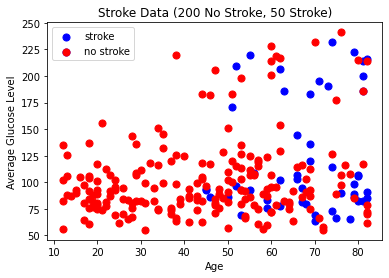

In [58]:
negative = plt.scatter(x1,y1,s=50, c = "blue")
positive = plt.scatter(x2,y2,s=50, c="red")
plt.legend([negative, (negative, positive)],["stroke", "no stroke"])
plt.xlabel("Age")
plt.ylabel("Average Glucose Level")
plt.title("Stroke Data (200 No Stroke, 50 Stroke)")

In [66]:
X = stroke_sample.drop("stroke", axis = 1)
y = stroke_sample["stroke"]
sm = SMOTE()
X, y = sm.fit_resample(X,y)

Text(0.5, 1.0, 'Stroke Data After SMOTE (200 No Stroke, 200 Stroke)')

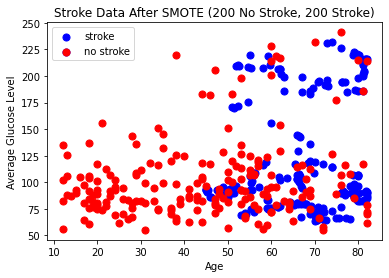

In [76]:
smote_sample = pd.concat([X, y], axis = 1)
x1 = smote_sample[smote_sample["stroke"] == 1]["age"]
y1 = smote_sample[smote_sample["stroke"] == 1]["avg_glucose_level"]
x2 = smote_sample[smote_sample["stroke"] == 0]["age"]
y2 = smote_sample[smote_sample["stroke"] == 0]["avg_glucose_level"]
negative = plt.scatter(x1,y1,s=50, c = "blue")
positive = plt.scatter(x2,y2,s=50, c="red")
plt.legend([negative, (negative, positive)],["stroke", "no stroke"])
plt.xlabel("Age")
plt.ylabel("Average Glucose Level")
plt.title("Stroke Data After SMOTE (200 No Stroke, 200 Stroke)")


## Analysis of Tests

A data set of values for different training sets and layer numbers was setup for analysis.  Each was run independently and then exported as a CSV file.  These were imported into excel for basic combining.  A master CSV was generated to allow comparison of conditions.

In [ ]:
# loading data
nn_perf_df = pd.read_csv("support_docs\master_data_NN.csv")

In [ ]:
nn_perf_df

In [ ]:
nn_perf_df["Layers"].value_counts()

In [ ]:
nn_perf_df["Accuracy"] = (nn_perf_df["Accuracy"].str.strip("%").astype(float))
nn_perf_df["Precision"] = (nn_perf_df["Precision"].str.strip("%").astype(float))
nn_perf_df["Recall"] = (nn_perf_df["Recall"].str.strip("%").astype(float))
nn_perf_df["F1"] = (nn_perf_df["F1"].str.strip("%").astype(float))

In [ ]:
nn_perf_df.dtypes

In [ ]:
nn_perf_df["Layer 1"].value_counts()

In [ ]:
# Effect of Layers and Training Size

from matplotlib import cm
layers = [1,4]
training = [548, 20000]

#plot 1
red_diamond = dict(markerfacecolor='r', marker='D')
fig = plt.figure(figsize = (15,12))
ax1 = fig.add_subplot(321)
#fig1, ax1 = plt.subplots()
ax1.set_title('Accuracy vs Number of Layers')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(-5,100)
ax1.boxplot([nn_perf_df["Accuracy"][nn_perf_df["Layers"]==layers[i]] for i in range(0,len(layers))], labels=layers, showfliers = True,
           flierprops = red_diamond)

#plot 2
ax2 = fig.add_subplot(322)
#fig1, ax1 = plt.subplots()
ax2.set_title('Recall vs Number of Layers')
ax2.set_ylabel('Recall')
ax2.set_ylim(-5,100)

x=[]
y =[]
for i in range(0,len(nn_perf_df)):
    if nn_perf_df.iloc[i][3] == 4:
        x.append(1.75)
    else:
        x.append(0.75)
    y.append(nn_perf_df.iloc[i][27])
ax2.scatter(x,y, c=cm.prism(x), alpha = 0.4)
ax2.boxplot([nn_perf_df["Recall"][nn_perf_df["Layers"]==layers[i]] for i in range(0,len(layers))], labels=layers, showfliers = True,
          flierprops = red_diamond)

#plot 3
ax3 = fig.add_subplot(323)
#fig1, ax1 = plt.subplots()
ax3.set_title('Accuracy vs Training Size')
ax3.set_ylabel('Accuracy')
ax3.set_ylim(-5,100)
ax3.boxplot([nn_perf_df["Accuracy"][nn_perf_df["N-Negative"]==training[i]] for i in range(0,len(training))], labels=training, showfliers = True,
           flierprops = red_diamond)

#plot4
ax4 = fig.add_subplot(324)
#fig1, ax1 = plt.subplots()
ax4.set_title('Recall vs Training Size')
ax4.set_ylabel('Recall')
ax4.set_ylim(-5,100)
ax4.boxplot([nn_perf_df["Recall"][nn_perf_df["N-Negative"]==training[i]] for i in range(0,len(training))], labels=training, showfliers = True,
           flierprops = red_diamond)

#plot5
x=[]
y =[]
for i in range(0,len(nn_perf_df)):
    if nn_perf_df.iloc[i][0] == 20000:
        x.append(1.75)
    else:
        x.append(0.75)
    y.append(nn_perf_df.iloc[i][26])
    
ax4 = fig.add_subplot(325)
#fig1, ax1 = plt.subplots()
ax4.set_title('Precision vs Training Size')
ax4.set_ylabel('Precision')
ax4.set_ylim(-5,100)
ax4.boxplot([nn_perf_df["Precision"][nn_perf_df["N-Negative"]==training[i]] for i in range(0,len(training))], labels=training, showfliers = True,
           flierprops = red_diamond)
ax4.scatter(x,y, c=cm.prism(x), alpha = 0.4)

#plot6
ax4 = fig.add_subplot(326)
#fig1, ax1 = plt.subplots()
ax4.set_title('F1 vs Training Size')
ax4.set_ylabel('F1')
ax4.set_ylim(-5,100)
ax4.boxplot([nn_perf_df["F1"][nn_perf_df["N-Negative"]==training[i]] for i in range(0,len(training))], labels=training, showfliers = True,
           flierprops = red_diamond)

plt.show()



In [ ]:
type(x[1])


In [ ]:
type(layers[1])